# Object detection with Keras and TS

- Documentation : https://www.tensorflow.org/hub/tutorials/object_detection?hl=fr

## Setup

In [ ]:
%pip install -q tflite-model-maker
%pip install -q tflite-support
%pip install opencv-python-headless==4.5.2.52
!pip3 install pycocotools



try:
# pylint: disable=g-import-not-at-top
  from pycocotools.coco import COCO
  from pycocotools.cocoeval import COCOeval
# pylint: enable=g-import-not-at-top
except ImportError:
  print('Erreur')


In [ ]:
import numpy as np
import os

from tflite_model_maker.config import QuantizationConfig
from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

## Chargement du jeu de données

In [ ]:
train_folder = 'datasets/dataset.voc/train'
val_folder = 'datasets/dataset.voc/valid'
test_folder = 'datasets/dataset.voc/test'

# These images are used to train the object detection model to recognize plastic and can
train_data = object_detector.DataLoader.from_pascal_voc(
    train_folder,
    train_folder,
    ['plastique','canette']
)

# These images are used to evaluate the model. 
# These are images that the model didn't see during the training process. You'll use them to decide when you should stop the training, to avoid overfitting.
val_data = object_detector.DataLoader.from_pascal_voc(
    val_folder,
    val_folder,
    # label_map={1: "plastique", 2: "canette"}
    ['plastique','canette']
)

# These images are used to evaluate the final model performance.
test_data = object_detector.DataLoader.from_pascal_voc(
    test_folder,
    test_folder,
    ['plastique','canette']
)

## Mise en cache des données

In [ ]:
# AUTOTUNE = tf.data.AUTOTUNE

# train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

## Selection du modèle

In [ ]:
# Liste des modèles possibles : https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/model_spec
# spec = model_spec.get('mobilenet_v2')
# spec = model_spec.get('efficientdet_lite4')

verbose=1
tflite_max_detections=2

spec = model_spec.get('efficientdet_lite3')
spec.tflite_max_detections=tflite_max_detections
spec.verbose=verbose


## Entrainement du modèle

In [ ]:
# Entraîner entièrement le modèle (fine-tuning) ?
train_whole_model=True
epochs=80
batch_size=5
model = object_detector.create(train_data, 
                               validation_data=val_data,
                               model_spec=spec, 
                               train_whole_model=train_whole_model,
                               epochs=epochs,
                               batch_size=batch_size
                               )


In [ ]:
print(model)

summary = model.summary()

print(summary)

## Evaluation du modèle

In [ ]:
# https://cocodataset.org/#detection-eval
# val_loss, val_accuracy = model.evaluate(val_data)

evaluation = model.evaluate(val_data)

# print(evaluation)

def plotEvaluation(eval, title="Résultats de l\'évaluation du modèle'"):
    import matplotlib.pyplot as plt
    plt.bar(eval.keys(), eval.values(), color='skyblue')
    plt.xlabel('Métrique')
    plt.ylabel('Valeur')
    plt.title(title)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# Création du graphique
# import matplotlib.pyplot as plt
# plt.figure(figsize=(14, 8))
# plt.bar(evaluation.keys(), evaluation.values(), color='skyblue')
# plt.xlabel('Métrique')
# plt.ylabel('Valeur')
# plt.title('Résultats de l\'évaluation du modèle')
# plt.xticks(rotation=45, ha="right")
# plt.tight_layout()  # Ajuste automatiquement les paramètres du subplot pour donner un padding spécifié

# # Afficher le graphique
# plt.show()
plotEvaluation(evaluation)

## Export du modèle au format Tensorflow lite

In [ ]:
model.export(export_dir='bin/', tflite_filename='greengardians.tflite')


## Evaluation du modèle entrainé

In [ ]:
model_path = 'bin/greengardians.tflite'
evaluation_lite = model.evaluate_tflite(model_path, test_data)

plotEvaluation(evaluation_lite)

In [ ]:
NUMBER_OF_TPUS =  2

!edgetpu_compiler 'bin/greengardians.tflite' --num_segments=$NUMBER_OF_TPUS

## Utilitaires

In [16]:
import cv2

from PIL import Image

# Load the labels into a list
# classes = ['???'] * model.model_spec.config.num_classes
# label_map = model.model_spec.config.label_map
# for label_id, label_name in label_map.as_dict().items():
#   classes[label_id-1] = label_name

classes = {0: "plastique", 1: "canette"}
print('classes', classes)

# Define a list of colors for visualization
COLORS = np.random.randint(0, 255, size=(len(classes), 3), dtype=np.uint8)

def preprocess_image(image_path, input_size):
  """Preprocess the input image to feed to the TFLite model"""
  img = tf.io.read_file(image_path)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.uint8)
  original_image = img
  resized_img = tf.image.resize(img, input_size)
  resized_img = resized_img[tf.newaxis, :]
  resized_img = tf.cast(resized_img, dtype=tf.uint8)
  return resized_img, original_image


def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""

  signature_fn = interpreter.get_signature_runner()

  # Feed the input image to the model
  output = signature_fn(images=image)


  # Get all outputs from the model
  count = int(np.squeeze(output['output_0']))
  scores = np.squeeze(output['output_1'])
  classes = np.squeeze(output['output_2'])
  boxes = np.squeeze(output['output_3'])


  results = []
  for i in range(count):
    if scores[i] >= threshold:
      result = {
        'bounding_box': boxes[i],
        'class_id': classes[i],
        'score': scores[i]
      }
      results.append(result)
  return results

def run_odt_and_draw_results(image_path, interpreter, threshold=0.5):
  """Run object detection on the input image and draw the detection results"""
  # Load the input shape required by the model
  _, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

  # Load the input image and preprocess it
  preprocessed_image, original_image = preprocess_image(
      image_path,
      (input_height, input_width)
    )

  # Run object detection on the input image
  results = detect_objects(interpreter, preprocessed_image, threshold=threshold)

  print('results', results)

  # Plot the detection results on the input image
  original_image_np = original_image.numpy().astype(np.uint8)
  for obj in results:
    # Convert the object bounding box from relative coordinates to absolute
    # coordinates based on the original image resolution
    ymin, xmin, ymax, xmax = obj['bounding_box']
    xmin = int(xmin * original_image_np.shape[1])
    xmax = int(xmax * original_image_np.shape[1])
    ymin = int(ymin * original_image_np.shape[0])
    ymax = int(ymax * original_image_np.shape[0])

    # Find the class index of the current object
    class_id = int(obj['class_id'])

    # Draw the bounding box and label on the image
    color = [int(c) for c in COLORS[class_id]]
    cv2.rectangle(original_image_np, (xmin, ymin), (xmax, ymax), color, 2)
    # Make adjustments to make the label visible for all objects
    y = ymin - 15 if ymin - 15 > 15 else ymin + 15
    label = "{}: {:.0f}%".format(classes[class_id], obj['score'] * 100)
    cv2.putText(original_image_np, label, (xmin, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

  # Return the final image
  original_uint8 = original_image_np.astype(np.uint8)
  return original_uint8

classes {0: 'plastique', 1: 'canette'}


## Prediction

In [31]:
# Load the TFLite model
import os
from pathlib import Path
model_path = 'bin/greengardians.tflite'

interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# # Run inference and draw detection result on the local copy of the original file
DETECTION_THRESHOLD = 0.5
# IMG_FILE = 'datasets/dataset.voc/test/IMG_20231025_095509_jpg.rf.c83cb3628dda974ef28a37ce404b9ab7.jpg'
          
PROJECT_FOLDER = Path(Path.cwd())
image_folder = str(PROJECT_FOLDER) + '/datasets/dataset.voc/test/'
                                                          
l_detection_result_image = []
files = [image_folder +'/'+ f for f in os.listdir(image_folder) if f.endswith('.jpg')]
for file in files:
    detection_result_image = run_odt_and_draw_results(
        file,
        interpreter,
        threshold=DETECTION_THRESHOLD
    )
    l_detection_result_image.append(detection_result_image)
    print(file)

results [{'bounding_box': array([0.16295412, 0.44729245, 0.6907692 , 0.63238394], dtype=float32), 'class_id': 1.0, 'score': 0.8828125}]
/home/charles/web/alyra/villepropre/vp-server/train/datasets/dataset.voc/test//IMG_20231025_095308_jpg.rf.0cf99dfb717a009ec728044cbb0246ce.jpg
results [{'bounding_box': array([0.28574514, 0.4219718 , 0.64214575, 0.5770754 ], dtype=float32), 'class_id': 0.0, 'score': 0.84765625}, {'bounding_box': array([0.11184406, 0.7744988 , 0.80834323, 0.99039125], dtype=float32), 'class_id': 0.0, 'score': 0.80859375}]
/home/charles/web/alyra/villepropre/vp-server/train/datasets/dataset.voc/test//IMG_20231025_095509_jpg.rf.c83cb3628dda974ef28a37ce404b9ab7.jpg
results [{'bounding_box': array([0.04060754, 0.41121346, 0.6331514 , 0.5812509 ], dtype=float32), 'class_id': 0.0, 'score': 0.7109375}]
/home/charles/web/alyra/villepropre/vp-server/train/datasets/dataset.voc/test//IMG_20231025_095551_jpg.rf.e9c4c8a8269fa8ee0dc5506535293ab1.jpg
results [{'bounding_box': array([0

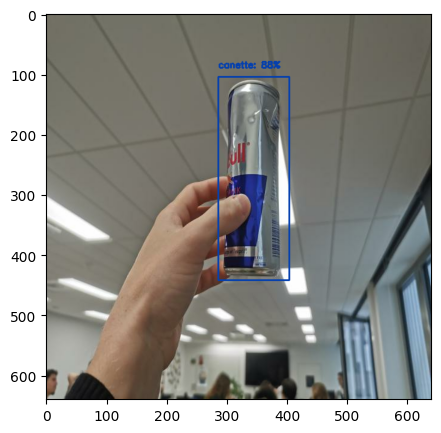

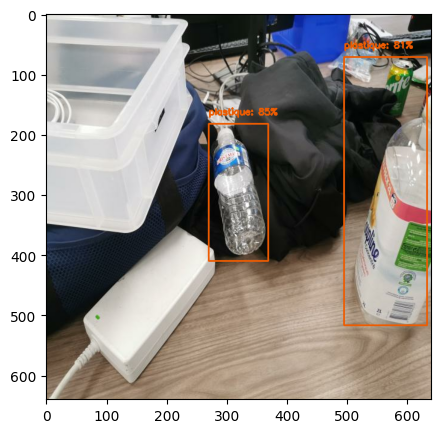

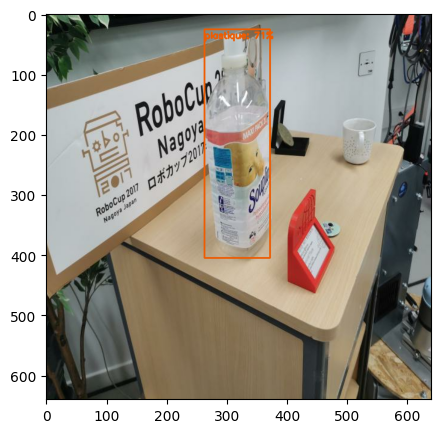

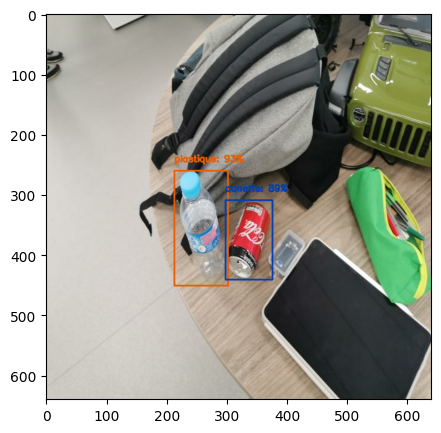

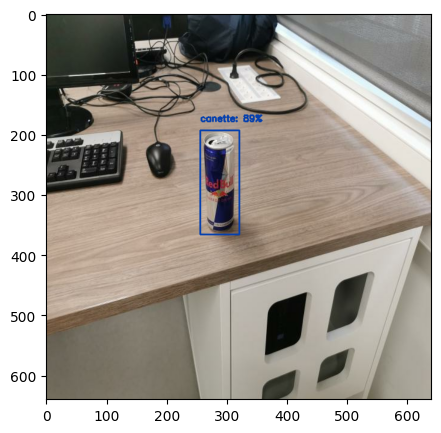

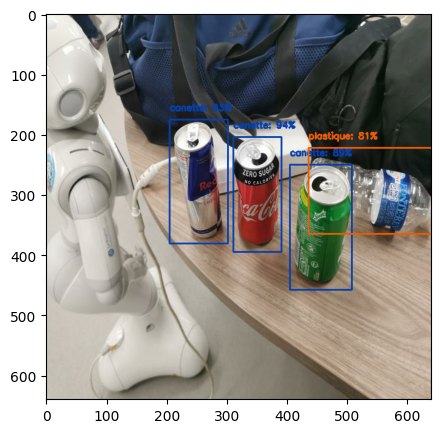

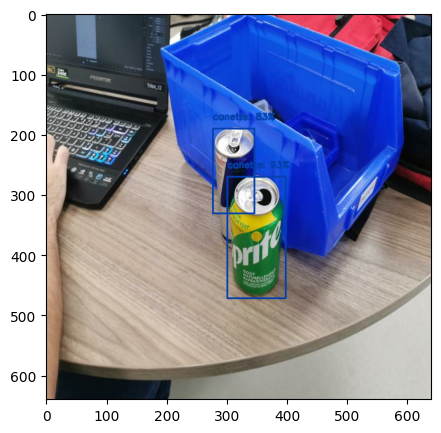

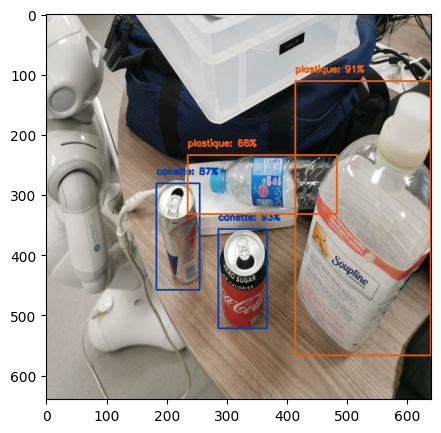

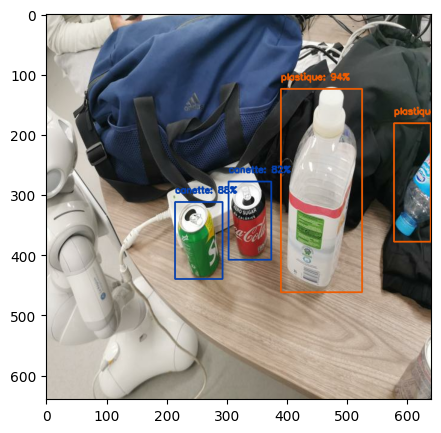

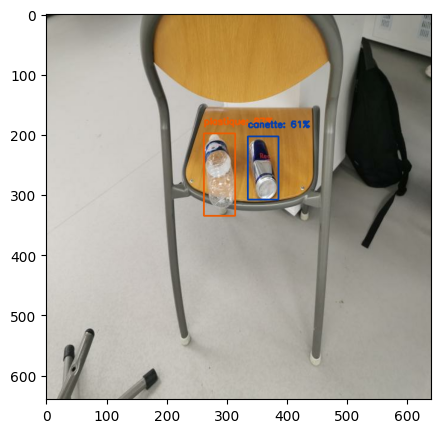

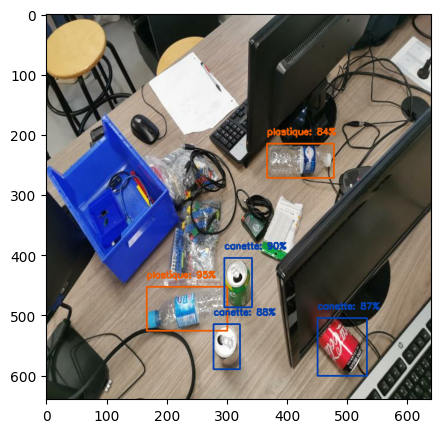

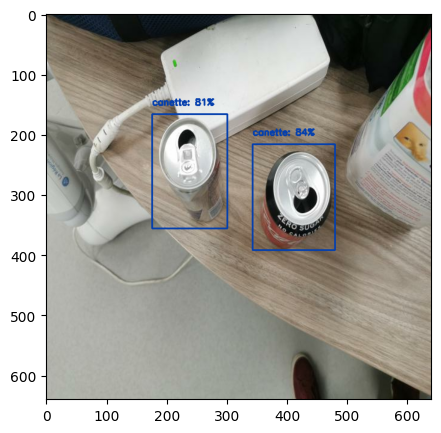

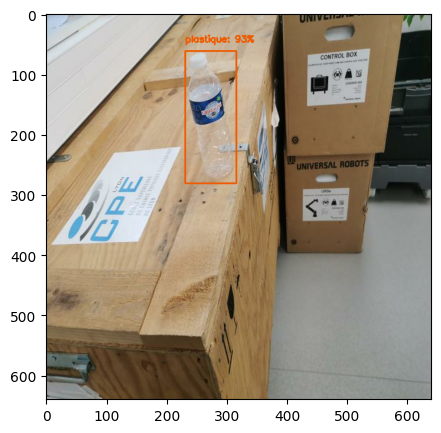

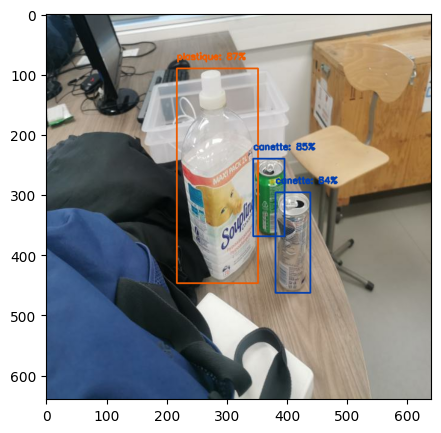

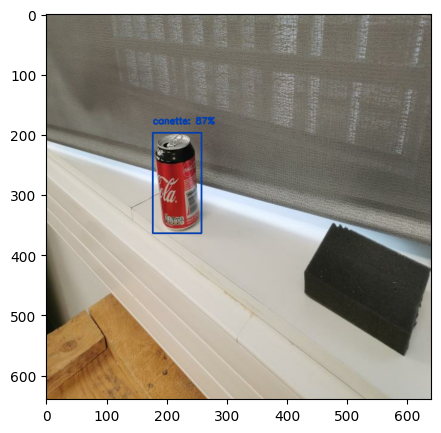

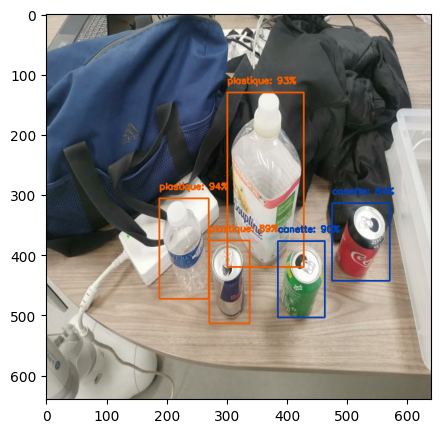

In [47]:
import matplotlib.pyplot as plt
test_validation_folder = str(PROJECT_FOLDER) + '/datasets/dataset.voc/test_val/'

# Show all the detection result
for image in l_detection_result_image:
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.show()
    # Save the image in the validation folder    
    plt.close()